[WARN] LSTM model not found; will plot classical models only.
[INFO] Base (non-lag) features found for LSTM: 9
['tmin', 'tmax', 'soil_temp_5cm', 'soil_temp_10cm', 'soil_temp_20cm', 'soil_temp_50cm', 'soil_moisture_0_5cm', 'rainfall', 'discharge']
[WARN] Missing classical model file: logistic_regression_flood_model.pkl (skipping Logistic Regression)
[WARN] Missing classical model file: random_forest_flood_model.pkl (skipping Random Forest)


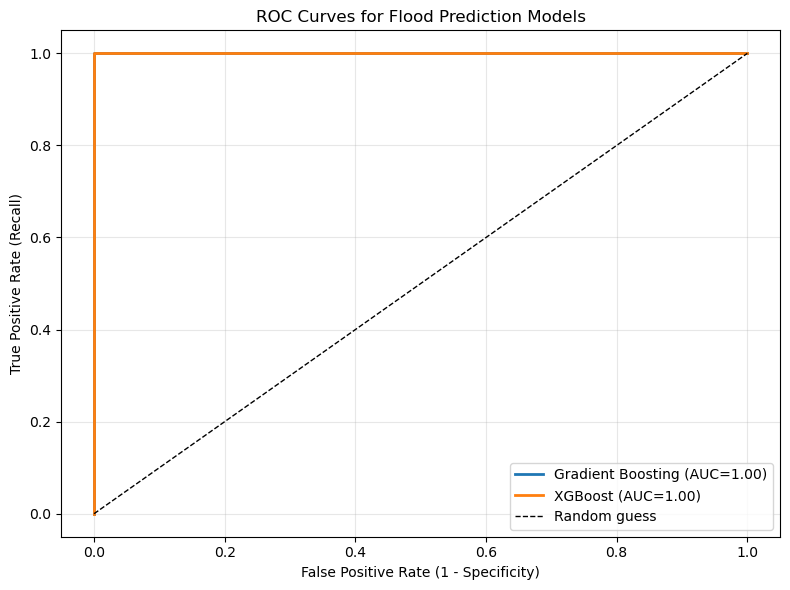

[OK] Saved: roc_curves_all_models.png


In [4]:
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf


LAGGED_CSV  = "flood_model_lagged.csv"    
LABELED_CSV = "flood_model_labeled.csv"    
LABEL_COL = "flood"
DATE_COL  = "date"

CLASSICAL_MODELS = {
    "Logistic Regression": "logistic_regression_flood_model.pkl",
    "Random Forest":       "random_forest_flood_model.pkl",
    "Gradient Boosting":   "gb_flood_model.pkl",
    "XGBoost":             "xgb_flood_model.pkl",
}

LSTM_MODEL_PATH = "lstm_flood_model.h5"
LOOKBACK = 7
TEST_SIZE = 0.20
SHUFFLE_SPLIT = False
OUTPUT_FIG = "roc_curves_all_models.png"

LSTM_FEATURE_LIST = None

def is_lag_col(colname: str) -> bool:

    return re.match(r".*_lag_?\d+$", colname) is not None

def make_sliding_windows(X_df, y_ser, features, lookback=7):
    Xv = X_df[features].to_numpy(dtype="float32")
    yv = y_ser.to_numpy(dtype="float32")
    X_seq, y_seq = [], []
    for i in range(lookback, len(Xv)):
        X_seq.append(Xv[i-lookback:i, :])
        y_seq.append(yv[i])
    return np.array(X_seq), np.array(y_seq)


df_lagged = pd.read_csv(LAGGED_CSV)
X_lagged = df_lagged.drop(columns=[c for c in [LABEL_COL, DATE_COL] if c in df_lagged.columns])
y_lagged = df_lagged[LABEL_COL].astype(int)
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
    X_lagged, y_lagged, test_size=TEST_SIZE, shuffle=SHUFFLE_SPLIT
)


have_lstm = Path(LSTM_MODEL_PATH).exists()
if have_lstm:
    lstm = tf.keras.models.load_model(LSTM_MODEL_PATH)  
    _, model_timesteps, model_feats = lstm.input_shape
    if model_timesteps != LOOKBACK:
        LOOKBACK = model_timesteps
else:
    print("[WARN] LSTM model not found; will plot classical models only.")
    model_feats = None  


df_daily = pd.read_csv(LABELED_CSV)
all_cols = df_daily.columns.tolist()


auto_base_features = [c for c in all_cols if c not in (LABEL_COL, DATE_COL) and not is_lag_col(c)]


if LSTM_FEATURE_LIST is not None:
    base_features = LSTM_FEATURE_LIST[:]
    missing = [c for c in base_features if c not in df_daily.columns]
    if missing:
        raise ValueError(f"The following required LSTM features are missing from {LABELED_CSV}: {missing}")
else:
    base_features = auto_base_features

print(f"[INFO] Base (non-lag) features found for LSTM: {len(base_features)}")
print(base_features)


y_daily = df_daily[LABEL_COL].astype(int)


preds = {}


for name, path in CLASSICAL_MODELS.items():
    if not Path(path).exists():
        print(f"[WARN] Missing classical model file: {path} (skipping {name})")
        continue
    mdl = joblib.load(path)
    if hasattr(mdl, "predict_proba"):
        preds[name] = mdl.predict_proba(X_test_lag)[:, 1]
    else:
        # Rare fallback
        if hasattr(mdl, "decision_function"):
            sc = mdl.decision_function(X_test_lag)
            preds[name] = (sc - sc.min()) / (sc.max() - sc.min() + 1e-9)
        else:
            preds[name] = mdl.predict(X_test_lag).astype("float32")


y_eval = y_test_lag.to_numpy()  
if have_lstm:
    if len(base_features) != model_feats:
        print(
            f"\n[SKIP LSTM] Your LSTM expects {model_feats} base features per timestep, "
            f"but {LABELED_CSV} currently has {len(base_features)} base columns.\n"
            f"Tip: add the missing daily features (e.g., include rolling/API/extra soil temps) "
            f"or set LSTM_FEATURE_LIST to the exact 17 training features.\n"
        )
    else:
        
        X_daily = df_daily[base_features]
        X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(
            X_daily, y_daily, test_size=TEST_SIZE, shuffle=SHUFFLE_SPLIT
        )
       
        X_seq_test, y_seq_test = make_sliding_windows(X_test_day, y_test_day, base_features, lookback=LOOKBACK)
        if X_seq_test.shape[2] != model_feats:
            raise RuntimeError(f"Per-timestep features mismatch: {X_seq_test.shape[2]} vs expected {model_feats}")
        lstm_probs = lstm.predict(X_seq_test, verbose=0).ravel()
        preds["LSTM"] = lstm_probs

        
        min_len = min(len(y_seq_test), *[len(v) for v in preds.values()])
        y_eval = y_seq_test[-min_len:]
        for k in preds:
            preds[k] = preds[k][-min_len:]


plt.figure(figsize=(8, 6))
for name, y_scores in preds.items():
    m = min(len(y_eval), len(y_scores))
    fpr, tpr, _ = roc_curve(y_eval[:m], y_scores[:m])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for Flood Prediction Models")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_FIG, dpi=300)
plt.show()
print(f"[OK] Saved: {OUTPUT_FIG}")




/Users/fmhadiurrahman/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/fmhadiurrahman/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/fmhadiurrahman/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


[INFO] LSTM expects (timesteps=7, features=17)


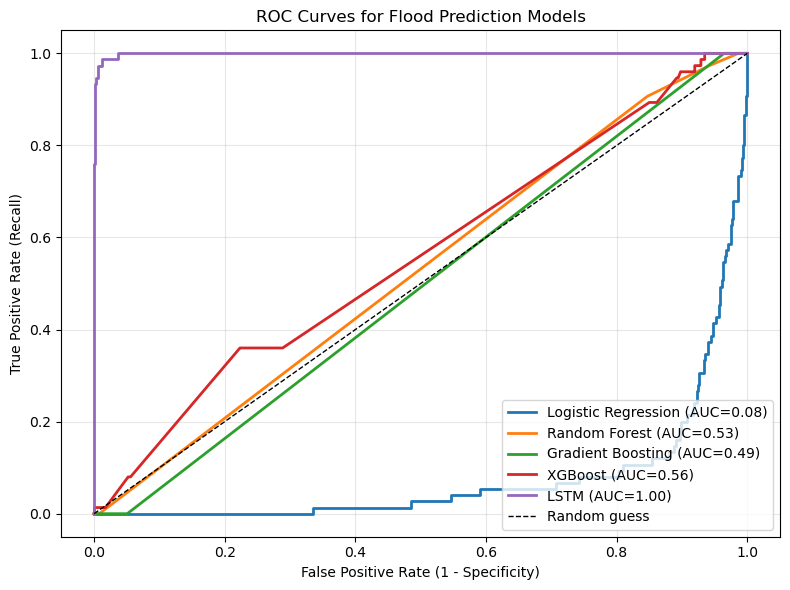

[OK] Saved: roc_curves_all_models.png


In [39]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf


LAGGED_CSV  = "flood_model_lagged.csv"     
LABEL_COL   = "flood"
DATE_COL    = "date"

CLASSICAL_MODELS = {
    "Logistic Regression": "logistic_regression_flood_model.pkl",
    "Random Forest":       "random_forest_flood_model.pkl",
    "Gradient Boosting":   "gb_flood_model.pkl",
    "XGBoost":             "xgb_flood_model.pkl",
}

LSTM_MODEL_PATH = "lstm_flood_model.h5"

LSTM_META_PATH  = "lstm_meta.joblib"  

TEST_SIZE   = 0.20
SHUFFLE     = False              
OUTPUT_FIG  = "roc_curves_all_models.png"

def make_sliding_windows_from_matrix(X_mat, y_vec, lookback):
    """X_mat: 2D (N, n_features); returns X_seq (N-lookback, lookback, n_features), y_seq aligned."""
    X_seq, y_seq = [], []
    for i in range(lookback, len(X_mat)):
        X_seq.append(X_mat[i-lookback:i, :])
        y_seq.append(y_vec[i])
    return np.array(X_seq, dtype="float32"), np.array(y_seq, dtype="float32")


lstm = tf.keras.models.load_model(LSTM_MODEL_PATH)
assert isinstance(lstm.input_shape, (list, tuple)) and len(lstm.input_shape) == 3, f"Unexpected LSTM input_shape: {lstm.input_shape}"
_, LSTM_LOOKBACK, LSTM_FEATS = lstm.input_shape
print(f"[INFO] LSTM expects (timesteps={LSTM_LOOKBACK}, features={LSTM_FEATS})")


features_order = None
scaler = None
if Path(LSTM_META_PATH).exists():
    meta = joblib.load(LSTM_META_PATH)
    features_order = meta.get("features")
    sc = meta.get("scaler")
    if isinstance(sc, str) and Path(sc).exists():
        scaler = joblib.load(sc)
    elif sc is not None:
        scaler = sc


df = pd.read_csv(LAGGED_CSV)
feat_cols = [c for c in df.columns if c not in (LABEL_COL, DATE_COL)]
assert len(feat_cols) == LSTM_FEATS, f"Lagged file must have {LSTM_FEATS} feature columns, found {len(feat_cols)}"


if features_order is not None:
    missing = [c for c in features_order if c not in feat_cols]
    assert not missing, f"Missing columns required by LSTM meta: {missing}"
    feat_cols = features_order[:] 

X_all = df[feat_cols].to_numpy(dtype="float32")
y_all = df[LABEL_COL].astype(int).to_numpy()


if scaler is not None:
    X_all = scaler.transform(X_all).astype("float32")


X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, shuffle=SHUFFLE
)


preds = {}
for name, path in CLASSICAL_MODELS.items():
    if not Path(path).exists():
        print(f"[WARN] Missing model: {path} — skipping {name}")
        continue
    mdl = joblib.load(path)
    if hasattr(mdl, "predict_proba"):
        probs = mdl.predict_proba(X_test)[:, 1]
    elif hasattr(mdl, "decision_function"):
        scores = mdl.decision_function(X_test)
        smin, smax = scores.min(), scores.max()
        probs = (scores - smin) / (smax - smin + 1e-9)
    else:
        probs = mdl.predict(X_test).astype("float32")
    preds[name] = probs


X_seq_test, y_seq_test = make_sliding_windows_from_matrix(X_test, y_test, lookback=LSTM_LOOKBACK)
assert X_seq_test.shape[2] == LSTM_FEATS, "Per-timestep feature count mismatch"

lstm_probs = lstm.predict(X_seq_test, verbose=0).ravel()
preds["LSTM"] = lstm_probs

min_len = min(len(y_seq_test), *[len(v) for v in preds.values()])
y_eval = y_seq_test[-min_len:]
for k in preds:
    preds[k] = preds[k][-min_len:]


plt.figure(figsize=(8, 6))
for name, y_scores in preds.items():
    fpr, tpr, _ = roc_curve(y_eval, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for Flood Prediction Models")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_FIG, dpi=300)
plt.show()
print(f"[OKk] Saved: {OUTPUT_FIG}")


